# 1 - Importando Bibliotecas e recursos

In [1]:
!pip install fastparquet Unidecode seaborn nltk scikit-learn wordcloud transformers datasets xgboost==0.90

In [2]:
import pandas as pd
import fastparquet

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from string import punctuation
from nltk import tokenize, ngrams
import unidecode
import numpy as np
import re
import os
import shutil

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, ConfusionMatrixDisplay


from wordcloud import WordCloud
import matplotlib.pyplot as plt

#---------- Recursos ----------#
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')


from joblib import dump, load


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\degio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\degio\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\degio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:

df = pd.read_parquet(r'.\B2W-Reviews01-tratada-v2.parquet')
df.head()

,submission_date,reviewer_id,product_id,product_name,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_gender,reviewer_state,idade,review_id,polarity
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,F,RJ,65.0,0,Positivo
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",M,SC,27.0,1,Positivo
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,M,SP,39.0,2,Positivo
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,F,SP,38.0,3,Positivo
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",M,MG,29.0,4,Positivo


## 2 -  Transformando o problema em um modelo Binário

Reparamos que a escala de 1 a 5 é apenas uma classificação. O verdadeiro preenchimento é categorico e tem um sentido léxico bem diferente.

![image.png](attachment:image.png)

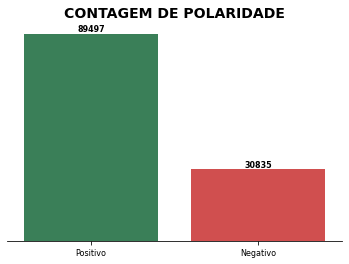

In [4]:
colors_polarity = ['#2E8B57', '#e53a3a']
ax = sns.countplot(data=df, x='polarity', palette=colors_polarity)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',
                fontsize=8, fontweight='bold', color='black')

sns.despine()
ax.yaxis.set_ticks([])
plt.ylabel('')
plt.xlabel('')
ax.set_title('CONTAGEM DE POLARIDADE', fontsize=14, fontweight='bold', color='black')

ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', colors='black', labelsize=8)
ax.spines['bottom'].set_color('black')
ax.set_facecolor('none')
ax.title.set_y(1.08)

fig = plt.gcf()
fig.patch.set_facecolor('none')

plt.xlabel('')
plt.show()


#3 - Tratamento do texto

In [5]:
def tratar(df, coluna):

  palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
  pontuacao = []
  for ponto in punctuation:
    pontuacao.append(ponto)
  pontuacao_stopwords = pontuacao + palavras_irrelevantes
  token_pontuacao = tokenize.WordPunctTokenizer()
  sem_acentos = [unidecode.unidecode(texto) for texto in df[coluna]]
  stopwords_sem_acentos = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]
  stemmer = nltk.RSLPStemmer()

  df['texto_tratado'] = sem_acentos

  frase_processada = []

  for texto in df['texto_tratado']:

    nova_frase = []
    texto = texto.lower()
    texto = texto.replace('http','')
    texto = texto.replace('...','')
    texto = texto.replace('://','')
    texto = texto.replace('..','')
    texto = re.sub('\d','', texto)
    palavras_texto = token_pontuacao.tokenize(texto)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(' '.join(nova_frase))

  df['texto_tratado'] = frase_processada

In [6]:
tratar(df,'review_text')

In [7]:
def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Real')
    plt.show()

# 4 - Baseline Binário

## 4.1 - Logistic Regression

In [8]:
# Abordagem de Polaridade
var='polarity'
X = df['texto_tratado']
y = df[var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
vectorizer = TfidfVectorizer(max_df = 0.4, ngram_range = (1,3), max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
classifier = LogisticRegression(max_iter = 500, class_weight='balanced')
classifier.fit(X_train_tfidf, y_train)
X_test_tfidf = vectorizer.transform(X_test)
y_pred = classifier.predict(X_test_tfidf)
b_accuracy = balanced_accuracy_score(y_test, y_pred)
print('#------------------------------------------------------------#')
print("Balanced Accuracy:", b_accuracy)
print('#------------------------------------------------------------#')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print('#------------------------------------------------------------#')
print(classification_report(y_test, y_pred))
print('#------------------------------------------------------------#')
c_r = classification_report(y_test, y_pred)

#------------------------------------------------------------#
Balanced Accuracy: 0.9181414361164155
#------------------------------------------------------------#
Accuracy: 0.9104998545726514
#------------------------------------------------------------#
              precision    recall  f1-score   support

    Negativo       0.77      0.93      0.84      6184
    Positivo       0.98      0.90      0.94     17883

    accuracy                           0.91     24067
   macro avg       0.87      0.92      0.89     24067
weighted avg       0.92      0.91      0.91     24067

#------------------------------------------------------------#


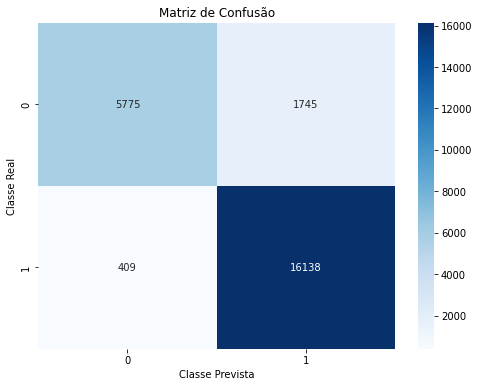

In [10]:
cm_log = confusion_matrix(y_pred,y_test)
plot_confusion_matrix(cm_log)

In [11]:
y_prob = classifier.predict_proba(X_test_tfidf)

In [12]:
ranges = list(np.arange(0, 1, .005))

In [13]:
from sklearn.metrics import  precision_score, recall_score, precision_recall_curve

In [14]:
y_test = np.array([1 if x =='Negativo' else 0 for x in y_test])

In [16]:
revocacao = []
precisao = []


for i in ranges:
    y_pred_sim = np.array([1 if x > i else 0 for x in list(y_prob[:,0])])
    revocacao.append(recall_score(y_test, y_pred_sim))
    precisao.append(precision_score(y_test, y_pred_sim))

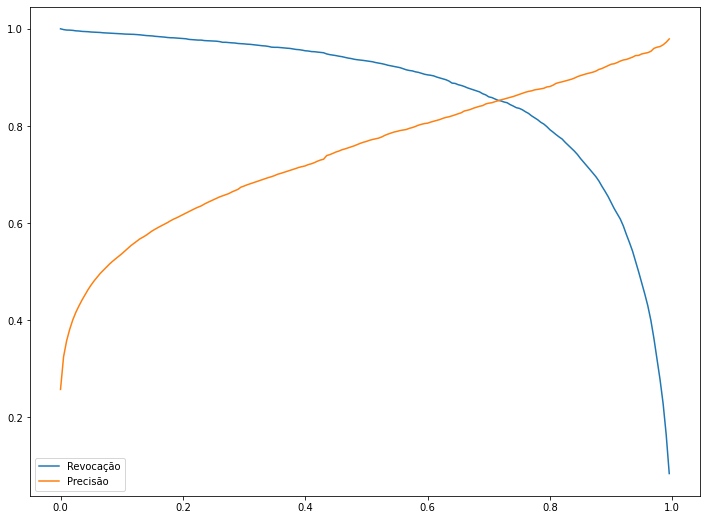

In [17]:
plt.figure(figsize = (12,9))
plt.plot(ranges, revocacao)
plt.plot(ranges, precisao)
plt.legend(['Revocação', 'Precisão'])
plt.show()